The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_{n-j+1} M u^{j}
$$

The fokker plank equation:
$$
u - \nabla \cdot(^R∂_t^{1-α} κ_α ∇u - \boldsymbol{F} ^R∂_t^{1-α }u) = f \qquad \text{in} \quad Ω × (0,T]
$$
subject to the initial and boundary conditions. This can be further simplified into 
$$
\partial_t^α u - κ_α Δu + ∇⋅κ_α ∇u+ \nabla \cdot( \boldsymbol{F} u) = f 
$$

Introducing $\boldsymbol{σ} = -κ_α \nabla u + {\bf F} u$ so that

$$
κ_α^{-1} \boldsymbol{σ} + ∇u = κ_α^{-1}{\bf F}u.
$$

The weak/discrete form is:
$$
\left(∂_t^α u, v\right) + \left(\nabla \cdot \boldsymbol{σ}, v\right) = \left(f,v\right) \qquad ∀ v\in V \\ 
\left(κ^{-1} \boldsymbol{σ}, \boldsymbol{\tau}\right) - \left(u, ∇⋅\boldsymbol{\tau}\right) -\left(κ_α^{-1}{\bf F}u,\boldsymbol{\tau}\right) =0 \qquad \forall \boldsymbol{\tau} \in {\bf W}
$$

In [172]:
module FractionalFokkerMixedConvQuad

using LinearAlgebra
using Printf
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SpecialFunctions

"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ϵ, p=1, α=1.0)
    γ= DataFunction([0.0]; name = "γ")    
    function coeffbeta!(result, x, t)
        result[1] = x[1];
        result[2] = x[2];
    end    
    β = DataFunction(coeffbeta!, [2,2]; name="β", dependencies="XT", bonus_quadorder=1)
    function exact!(result, x, t)
        result[1] = (x[1]-x[1]^2)*(x[2]-x[2]^2)*(1.0+t^α/gamma(α+1));
    end    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)    
    ∇u = eval_∇(u)
    function rhs!(result, x, t)
        u = (x[1]-x[1]^2)*(x[2]-x[2]^2)*(1.0+t^α/gamma(α+1));
        ux = (1-2*x[1])*(x[2]-x[2]^2)*(1.0+t^α/gamma(α+1));
        uxx = -2*(x[2]-x[2]^2)*(1.0+t^α/gamma(α+1));
        uy = (x[1]-x[1]^2)*(1-2*x[2])*(1.0+t^α/gamma(α+1)); 
        uyy = -2*(x[1]-x[1]^2)*(1.0+t^α/gamma(α+1));
        ut = (x[1]-x[1]^2)*(x[2]-x[2]^2); # time derivative is 1
        result[1] = ut - (uxx+uyy) + x[1]*ux+x[2]*uy + 2*u;
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)  

    return γ, β, u, ∇(u), f
end

function main(;ϵ=1.0, nrefinements=2, nsteps=10, T0=0, Tf=1.0, α=1, 
    tpower=1.0, verbosity=0, order = 1)
    # generating fractional derivative data
    ω = zeros(nsteps+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:nsteps+1
        ω[j] = (j-2-α)/(j-1)*ω[j-1]
    end
    # @show ω
    # computing the sum of ω
    sum_omega = zeros(nsteps+1)
    sum_omega[1] = ω[1]
    for j=2:nsteps+1
        sum_omega[j] = sum_omega[j-1] + ω[j]
    end
    # @show  sum_omega;
    
    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    # choose a finite element type

    FEType = [L2P0{1}, HDIVRT0{2}]
    if order == 2
      FEType = [H1P1{1}, HDIVRT1{2}]
    end
    #TODO: fix from the problem data
    u0 = DataFunction([0.0])

    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, tpower, α)

    # temp=div(β)
    # function div_kernel(result, input, x)
    #     # evaluate β
            
    #     eval_data!(temp)
    #     # compute β ⋅ \sigma
    #     result[1] = temp.val[1]*input[1]
    #     end
    #     action = Action(div_kernel, [1, 1]; dependencies = "X", bonus_quadorder = β.bonus_quadorder) 
    #     something = BilinearForm([Identity, Identity], action; factor = -1/ϵ)
    # end
    function convection_kernel(result, input, x, t)
        # evaluate β        
        eval_data!(β, x, t)
        # compute β ⋅ \sigma
            result[1] = 0.0
            result[2] = 0.0
        for k = 1 : 2
            result[k] += β.val[k]*input[1]
        end
    end
    action = Action(convection_kernel, [2, 1]; dependencies = "XT", bonus_quadorder = β.bonus_quadorder) 
    CO = BilinearForm([Identity, Identity], action; factor = -1/ϵ, transposed_assembly = false, apply_action_to=[2])

    ## load initial mesh
    #xgrid = grid_unitsquare(Triangle2D)
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = [FESpace{FEType[1]}(xgrid; broken = true), FESpace{FEType[2]}(xgrid)]
    # @show FES
    Solution = FEVector(FES)
    n_dofs = FES[1].ndofs + FES[2].ndofs
    interpolate!(Solution[1], u; time = 0.0)
    #@show Solution
    
    # matrices 
    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))    
    A = FEMatrix(FES)
    rhs = FEVector(FES)
        
    t0 = T0
    tau = (Tf - T0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES[1].ndofs+FES[2].ndofs, 1)
    #V1 = FEVector(FES)
    Mu0 = zeros(Float64, FES[1].ndofs+FES[2].ndofs)

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    SolVector = Array{FEVector{Float64}}([])
    # ndofs
    SolVector = zeros(Float64, n_dofs, nsteps)
    SolVector[:,1] = Solution[1].entries
    # @show norm(Solution.entries - SolVector[:,1])    
    # time loop
    l2u = zero(Float64); h1u = zero(Float64)
    l2sig = zero(Float64); oldl2sig=zero(Float64)
    eL2sig = zero(Float64)
    oldL2u = zero(Float64); oldh1u = zero(Float64)
    eL2u = zero(Float64); eh1u = zero(Float64)

    Mu0[:] = M.entries*Solution.entries
    scale = tau^α;
    # @show scale
    for m = 2:nsteps
        t0 = t0 + tau        
        # assemble rhs 
        fill!(SystemRHS.entries, 0)
        fill!(rhs.entries, 0)
        assemble_operator!(rhs[1], LinearForm(Identity, f; factor = 1.0); time=t0)
        assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES, factor = -1); time=t0)
        V1[:, 1] = rhs.entries

        fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
        fill!(A.entries.cscmatrix.nzval, 0)
        # assembling the matrices with coefficients depending on time     
        assemble_operator!(A[1,1], ReactionOperator(γ); time=t0)
        assemble_operator!(A[2,1], BilinearForm([Divergence, Identity]; factor = -1.0)) 
        assemble_operator!(A[1,2], BilinearForm([Identity, Divergence]; factor =  1.0))        
        assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
        assemble_operator!(A[2,1], CO; time = t0)
        #@show t0, m, sum_omega[m]
        # system left hand side 1/τ^α * (M + A)u^n; ω_0= 1.0
        addblock!(SystemMatrix[1, 1], M[1, 1]; factor= ω[1]/scale)

        addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
        addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
        addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)
        addblock!(SystemMatrix[2, 2], A[2, 2]; factor= 1.0)
        #@info "Preparing the rhs with right coefficients"
        # rhs at current time 
        addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
        # 1/tau^α * ∑ ω_j^α M u^0
        addblock!(SystemRHS[1], Mu0; factor= sum_omega[m-1]/scale)
        # @show sum_omega[m-1] # please check me once again
        # 1/τ^α * ∑_j=2^{n-1} ω_{n-j+1}^ℵ M u^j
        for j=2:m-1 
            addblock!(SystemRHS[1], M.entries*SolVector[:,j]; factor= -ω[m-j+1]/scale)
        end

        flush!(SystemMatrix.entries)      
        #@show SystemRHS.entries

        SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
        for j = 1 : n_dofs 
            Solution[1][j] = SystemSol[1][j]
        end

        # push!(SolVector, Solution)
        SolVector[:,m] = Solution[1].entries

        L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
        l2u = evaluate(L2Error_u, Solution[1])
        eL2u += (l2u + oldL2u) * tau * 0.5
        oldL2u = l2u
        h1u = L2ErrorIntegrator(∇u, Gradient; time= t0)
        h1u = evaluate(h1u, Solution[1])
        eh1u += (h1u + oldh1u) * tau * 0.5
        oldh1u = h1u

        function error_kernel(result, input, x)
            # evaluate β        
            eval_data!(β, x, t0)
            eval_data!(∇u, x, t0)
            # compute β ⋅ \sigma
                result[1] = 0.0                
            for k = 1 : 2
                result[1] += (input[1+k]-β.val[k]*input[1] + ∇u.val[k])^2
            end
        end
        action = Action(error_kernel, [1, 3]; dependencies = "X", bonus_quadorder = β.bonus_quadorder)         
        l2error_sigma = ItemIntegrator([Identity, Identity], action)        
        l2sig = evaluate(l2error_sigma, [Solution[1], Solution[2]])
        eL2sig += (l2sig + oldl2sig) * tau * 0.5
        oldl2sig = l2sig
        # @show sqrt(l2), sqrt(h1)
    end
    @show (sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig))
    (sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig))
end

end

Main.FractionalFokkerMixedConvQuad

In [173]:
ns = [2 4 8 16 32]
eL2u=[]; eH1u=[]; eL2S=[];
α = 0.3
t = α
for n in ns
    el2u, eh1u, el2s = 
        Main.FractionalFokkerMixedConvQuad.main(
            nrefinements=6, nsteps=n, α=α, tpower=t, order=2)
    push!(eL2u, el2u)
    push!(eH1u, eh1u)
    push!(eL2S, el2s)
end

(nrefinements, nsteps) = (6, 2)
(sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig)) = 

(0.0007302843572552335, 0.004691162495150606, 0.0032516675744471827, 0.00036514217862761676, 0.002345581247575303, 0.0016258337872235914)


(nrefinements, nsteps) = (6, 4)
(sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig)) = 

(0.00017789415024210072, 0.003683476089614794, 0.0007923695292833301, 0.0004560453761124031, 0.0033130539415177998, 0.0020306080722517967)


(nrefinements, nsteps) = (6, 8)
(sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig)) = 

(6.88188248897451e-5, 0.003697608223519789, 0.0003071777690359013, 0.0003873242997901324, 0.003453140006225726, 0.0017246538632816066)


(nrefinements, nsteps) = (6, 16)
(sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig)) = 

(3.108488615901499e-5, 0.003727822263794111, 0.00014010335615991833, 0.0003235135349273751, 0.0034761163380336653, 0.001440561427021236)


(nrefinements, nsteps) = (6, 32)
(sqrt(l2u), sqrt(h1u), sqrt(l2sig), sqrt(eL2u), sqrt(eh1u), sqrt(eL2sig)) = 

(1.5458102637460126e-5, 0.0037453310313619106, 7.220560182097842e-5, 0.0002696606575530443, 0.003460966920947966, 0.0012008084030860856)


L2u: Any[0.0007302843572552335, 0.00017789415024210072, 6.88188248897451e-5, 3.108488615901499e-5, 1.5458102637460126e-5]
L2s: Any[0.0032516675744471827, 0.0007923695292833301, 0.0003071777690359013, 0.00014010335615991833, 7.220560182097842e-5]


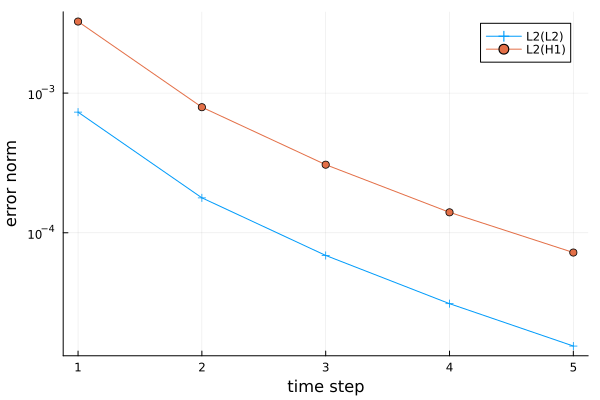

In [174]:
using Plots
println("L2u: ", eL2u)
println("L2s: ", eL2S)
taus = [ 1, 2, 3, 4, 5]
plot(taus,[eL2u eL2S],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)" "L2(L2)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

In [176]:
for i=1:5
    if i==1        
        println(i, " ", eL2u[i], " ----------------- ", eL2S[i], " ----------------- ")
    else
        println(i, " ", eL2u[i], " ", log2(eL2u[i-1]/eL2u[i]), 
        " ", eL2S[i], " ", log2(eL2S[i-1]/eL2S[i]))
    end
end

1 0.0007302843572552335 ----------------- 0.0032516675744471827 ----------------- 
2 0.00017789415024210072 2.0374392575489653 0.0007923695292833301 2.0369344675735657
3 6.88188248897451e-5 1.3701439079446256 0.0003071777690359013 1.367099592583119
4 3.108488615901499e-5 1.1465899623048401 0.00014010335615991833 1.132582293828749
5 1.5458102637460126e-5 1.0078500448868442 7.220560182097842e-5 0.9563088427239302
